# Notebook with examples on how to deal with intan data converted to kwik (and kwik).
Uses:
    - intan2kwik [multirec branch] (https://github.com/zekearneodo/intan2kwik/blob/multirec/README.md)
    - pipefinch (https://github.com/zekearneodo/pipefinch)
    
    - for sorting:
        - mountainlab suite(https://github.com/flatironinstitute/mountainlab-js)
        - mountainsort https://github.com/flatironinstitute/mountainsort_examples/blob/master/README.md
        - mountainsort examples https://github.com/flatironinstitute/mountainsort_examples/blob/master/README.md
        
Todo:
 - Separate intan2kiwk/kwd exploration from sorting
 - Make a little gui for the exploration
 - Make a decent pair of classes for sessions

In [1]:
import socket
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
from importlib import reload

# pipeline imports
from pipefinch.neural.convert import intan
from pipefinch.neural.sort.mountain import core as msc
from intan2kwik import kwd

#mountainsort imports (for sorting)
import mountainlab_pytools.mlproc as mlp

import logging

# Setup the logger
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)
        
logger.info('Logger set')

2019-01-17 18:05:50,874 - root - INFO - Logger set


### functions and definitions to prepare the file structure

In [2]:
locations_dict = {};
locations_dict['zebra'] = {'mnt': os.path.abspath('/data/experiment'),
                  'local': os.path.abspath('/data/experiment')}
locations_dict['ZOROASTRO'] = {'mnt': os.path.abspath('B:\microdrive\data'),
                  'local': os.path.abspath('D:\microdrive')}

def get_exp_struct_from_hostname():
    hostname = socket.gethostname()
    return locations_dict[hostname]

def get_exp_struct():
    # get the configuration of the experiment:
    # if environment variable 'EXPERIMENT_PATH' exists, 
    # read 'EXPERIMENT_PATH/config/expstruct.json'
    exp_struct = dict()
    read_exp_base = os.environ.get('EXPERIMENT_PATH')
    if read_exp_base is not None:
        # if there is a .json file configured with the variables of the experiment
        exp_base = os.path.abspath(read_exp_base)
        exp_struct_json_path = os.path.join(exp_base, 'exp_struct.json')
        exp_struct = read_json_exp_struct()
    else:
        # try to read it from the hostname
        exp_struct = get_exp_struct_from_hostname()
    
    # make the exp struct dict.
    # Todo: said
    
    return exp_struct

### Session parameters and raw files

In [3]:
sess_par = {'bird': 'o3g3',
           'sess': 'awake_mix_test',
            'neural': 'neural'}

def get_file_structure(sess_par: dict):
    exp_struct = get_exp_struct()
    
    exp_struct['raw_folder'] = os.path.join(exp_struct['mnt'], sess_par['bird'], sess_par['neural'], sess_par['sess'])
    exp_struct['ss_folder'] = os.path.join(exp_struct['local'], sess_par['bird'], 'ss_data', sess_par['sess'])
    return exp_struct

file_struct = get_file_structure(sess_par)

logger.info('Raw folder {}'.format(file_struct['raw_folder']))

#list all the files in the session
#glob.glob(os.path.join(raw_folder, '*.rhd'))

2019-01-17 18:05:54,027 - root - INFO - Raw folder /data/experiment/o3g3/neural/awake_mix_test


### convert the whole session to a .kwd file
Conversion sends every .rhd file in the folder to a rec in the .kwd file (experiment.kwd in the session ss folder)
All of the files and all of the channels are converted; filtering and subselection of sub-epochs and channels occurs later.
The .kwd is raw data, only in a friendlier format.


In [4]:
## Convert the whole session to a kwd file
ss_folder = file_struct['ss_folder']
raw_folder = file_struct['raw_folder']
kwd_path = os.path.join(ss_folder, 'experiment.kwd')
bin_path = os.path.join(ss_folder, 'experiment.bin')
os.makedirs(ss_folder, exist_ok=True)
first_intan_hdr, sess_pd = kwd.intan_to_kwd(raw_folder, kwd_path)

intan_to_raw generates a kwd file, and outputs a dictionary with the intan header of the first file, as well as a pandas DataFrame with metadata of all the recs created.

# Load and dig into a previously created .kwd file
Examples of the use of functions to read metadata, file contents and datasets from the .kwd files created

In [5]:
from pipefinch.h5tools.kwik import kwdfunctions as kwdf
from pipefinch.h5tools.kwik import kutil

### read all the meta of a kwd file into a pandas DataFrame

In [6]:
#reload(kwdf)
pd_meta = kwdf.get_all_rec_meta(kwd_path)
pd_meta.head(5)

,bit_depth,sample_rate,name,start_sample,start_time,is_multiSampleRate_data,channels_sample_rate,channel_bit_volts,channel_names,valid_samples,samples_count
0,16,20000.0,0,0,2018-09-08 14:34:46,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[A-001, A-002, A-003, A-004, A-006, A-008, A-0...","[12000240.0, 12000240.0, 12000240.0, 12000240....",12000240
1,16,20000.0,1,0,2018-09-08 18:55:37,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[A-001, A-002, A-003, A-004, A-006, A-008, A-0...","[24000480.0, 24000480.0, 24000480.0, 24000480....",24000480
2,16,20000.0,2,0,2018-09-08 19:15:38,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[A-001, A-002, A-003, A-004, A-006, A-008, A-0...","[24000480.0, 24000480.0, 24000480.0, 24000480....",24000480


### get a chunk in time and a set of channels and plot it.

#### read list of all channel names

In [8]:
# get the metadata for the rec (to get channel_names, for instance)
active_rec = 1
active_rec_meta = pd_meta[pd_meta.name == active_rec]

# get all the channel names
all_chan_names = kwdf.get_all_chan_names(active_rec_meta)
all_chan_names

array(['A-001', 'A-002', 'A-003', 'A-004', 'A-006', 'A-008', 'A-010',
       'A-012', 'A-013', 'A-014', 'A-017', 'A-019', 'A-021', 'A-022',
       'A-023', 'A-026', 'A-028', 'ADC-00'], dtype='<U6')

### find indices of all ephys channels from one port (A)

In [9]:
wanted_chans = np.array(['A-'])
sel_chan_names = kwdf.get_all_chan_names(pd_meta, chan_filt=wanted_chans)
sel_chan_names
sel_chan_idx = kwdf.find_chan_names_idx(all_chan_names, sel_chan_names)
sel_chan_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

## read one second of data at a starting point
function get_data_chunk is used to directly read selected channels from a chunk of a dataset.
It needs an open h5py.File object, rather than a path. The reason for this is that it is meant to be used when paging through files, so you don't want to add the overhead of opening the file (or decorating the function to check for it) every time you call it.

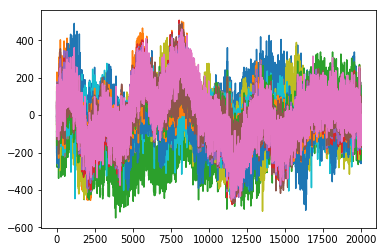

In [11]:
import h5py

start_ms = 30000
span_ms = 1000

s_f = kwdf.get_sampling_rate(active_rec_meta, active_rec)
start = int(start_ms*s_f*0.001)
span = int(span_ms*s_f*0.001)

# open the file in read mode
kwd_file = h5py.File(kwd_path, 'r')

# use function get_data_chunk to get a data chuunk from an open file
data_chunk = kwdf.get_data_chunk(kwd_file, active_rec, start, span, sel_chan_idx)

plt.plot(data_chunk);

# when you are done paging through, close the file
kwd_file.close()

## low level~ish: page through the dataset
The .kwd file is a hdf5 file. Each rec is a group that contains a dataset with the time series.
Rather than loading each dataset in memory, it is more efficient to get a pointer to the dataset, and then page through it.
This uses the h5py bindings for the hdf libraries (http://docs.h5py.org/en/stable/index.html)

In [12]:
import h5py
# open the file (and keep it open as long as reading from it is necessary)
kwd_file = h5py.File(kwd_path, 'r') # this opens the file, kwd_file is a pointer; nothing was loaded in memory.

# get a pointer to the dataset corresponding to a particular rec
active_rec = 0
rec_dset = kwdf.get_data_set(kwd_file, active_rec) # this retunrs a pointer to the dataset; again nothing was loaded in memory

# check out th shape of the dataset. It is an array, shaped [n_samples, n_channels]
logger.info('Dataset shape: {}'.format(rec_dset.shape))

# you don't want to leave the file open
kwd_file.close()
logger.warning('That said, one should not have to deal with the dataset directly, but through the helper functions defined in the kwdfunctions module.')

2019-01-17 18:07:28,119 - root - INFO - Dataset shape: (12000240, 18)
2019-01-17 18:07:28,121 - root - WARNING - That said, one should not have to deal with the dataset directly, but through the helper functions defined in the kwdfunctions module.


# Sorting with mountainsort
Below there are some steps to select a bunch of recs, create a file compatible with mountainsort, and do the sorting
 - working with the kwd_path, file_structure defined above

## Kwd file to mda 

### Select a subset of a kwd file:
 - a set of recordings (e.g, by range of time)
 - a set of channels (by identifier) (e.g: a whole port from the intan, like 'A-', or the channel where the mic is, like 'ADC-00')

##### Make .mda file with a set of recordings in a session
 - pick all in port A
 - get all rec within a time range


In [13]:
#### load all the meta
all_meta_pd = kwdf.get_all_rec_meta(kwd_path)

# trick: set the index to time
all_meta_pd.set_index('start_time', inplace=True)
all_meta_pd.head()

,bit_depth,sample_rate,name,start_sample,is_multiSampleRate_data,channels_sample_rate,channel_bit_volts,channel_names,valid_samples,samples_count
start_time,,,,,,,,,,
2018-09-08 14:34:46,16,20000.0,0,0,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[A-001, A-002, A-003, A-004, A-006, A-008, A-0...","[12000240.0, 12000240.0, 12000240.0, 12000240....",12000240
2018-09-08 18:55:37,16,20000.0,1,0,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[A-001, A-002, A-003, A-004, A-006, A-008, A-0...","[24000480.0, 24000480.0, 24000480.0, 24000480....",24000480
2018-09-08 19:15:38,16,20000.0,2,0,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[A-001, A-002, A-003, A-004, A-006, A-008, A-0...","[24000480.0, 24000480.0, 24000480.0, 24000480....",24000480


In [14]:
ch.setLevel(logging.INFO)

all_rec_list = kutil.get_rec_list(kwd_path)
all_rec_list

wanted_chans = np.array(['A-']) # all ephys channels in port A
period_start = '18:00'
period_end = '20:00'


chan_list = kwdf.get_all_chan_names(pd_meta, chan_filt=wanted_chans)
rec_list = kwdf.get_rec_range(pd_meta, period_start, period_end)

bin_path = os.path.join(ss_folder, 'raw.mda')
bin_file = kwdf.kwd_to_binary(kwd_path, bin_path, chan_list=(chan_list), rec_list=rec_list, header='mda')
rec_attr_dict = kwdf.get_rec_attrs(kwd_path, 0)
all_rec_meta_pd = kwdf.get_all_rec_meta(kwd_path)

#### test that the mda was written ok
(when in doubt, repeat the above for mic channel (wanted chans = np.array(['ADC-'])

In [15]:
from mountainlab_pytools import mdaio
loaded_mda = mdaio.readmda(bin_path)

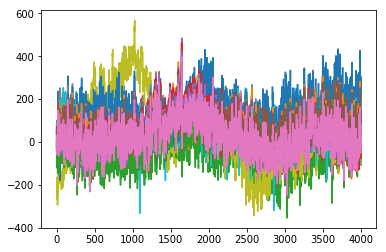

In [16]:
start = 8400000 + 30000
end = start + 4000
plt.plot(loaded_mda[:, start:end].T);

## Scripts for sorting

### prep the files with their nice formats, locations and names


In [17]:
ss_folder = file_struct['ss_folder']

file_paths, out_folder = msc.make_paths(ss_folder)
os.makedirs(ss_folder, exist_ok=True)
#todo:
# meta and pars from intan files et al
s_f = kwdf.get_sampling_rate(all_rec_meta_pd, rec_list[0])

# parameters to pass to the msort scripts
ds_params = {'samplerate': s_f,
            'detect_sign': -1}

with open(file_paths['params'], 'w') as fp:
    json.dump(ds_params, fp)
    logger.info('Created session par files {}'.format(file_paths['params']))
    
# create the mda file:
# In this case, use the mda created above, which is bin_path


#intan_meta, samples_in = intan.intan_to_bin(rhd_list[:], file_paths['mda'], variant='mda');


2019-01-17 18:07:56,299 - root - INFO - Created session par files /data/experiment/o3g3/ss_data/awake_mix_test/params.json


In [18]:
file_paths

{'mda': '/data/experiment/o3g3/ss_data/awake_mix_test/raw.mda',
 'params': '/data/experiment/o3g3/ss_data/awake_mix_test/params.json',
 'geom': '/data/experiment/o3g3/ss_data/awake_mix_test/geom.csv',
 'filt': '/data/experiment/o3g3/ss_data/awake_mix_test/sort_out/filt.mda.prv',
 'pre': '/data/experiment/o3g3/ss_data/awake_mix_test/sort_out/pre.mda.prv',
 'firings': '/data/experiment/o3g3/ss_data/awake_mix_test/sort_out/firings.mda',
 'firings_curated': '/data/experiment/o3g3/ss_data/awake_mix_test/sort_out/firings_curated.mda',
 'cluster_metrics': '/data/experiment/o3g3/ss_data/awake_mix_test/sort_out/cluster_metrics.json'}

In [19]:
# test mountainsort method for reading sorting parameters
msc.read_dataset_params(ss_folder)

{'samplerate': 20000.0, 'detect_sign': -1}

In [20]:
# Initialize a pipeline. It probably fails
from mountainlab_pytools import mlproc as mlp
Pipeline=mlp.initPipeline();

JSProxyWidget(status='Not yet rendered')

In [21]:
msc.sort_dataset?

Signature: msc.sort_dataset(*, file_paths:dict, freq_min:int=300, freq_max:int=6000, adjacency_radius:int=1, detect_threshold:float=3, dispatch_method:str='run', opts:dict={})
Docstring: <no docstring>
File:      ~/repos/pipefinch/pipefinch/neural/sort/mountain/core.py
Type:      function


In [ ]:
output_dir = os.path.join(ss_folder, 'sort_out');
# Pipeline was failing, need to debug this ('NameError: name 'widgets' is not defined')
# with Pipeline:
#     msc.sort_dataset(file_paths=file_paths, adjacency_radius=-1, detect_threshold=3, dispatch_method='add')

msc.sort_dataset(file_paths=file_paths, adjacency_radius=-1, detect_threshold=2, freq_min=600);

2019-01-17 18:08:01,345 - pipefinch.sort.mountain.comre - INFO - Bandpass filter


RUNNING: ml-run-process ephys.bandpass_filter --inputs timeseries:/data/experiment/o3g3/ss_data/awake_mix_test/raw.mda --parameters freq_max:6000 freq_min:600 samplerate:20000.0 --outputs timeseries_out:/data/experiment/o3g3/ss_data/awake_mix_test/sort_out/filt.mda.prv


2019-01-17 18:08:48,816 - pipefinch.sort.mountain.comre - INFO - Whitening


In [ ]:
file_paths

## Command for viewing:
 - open up terminal with the environment msort
 - go go the ss_data folder for the session
 - run the command: qt-mountainview --raw raw.mda --filt sort_out/filt.mda.prv --pre sort_out/pre.mda.prv --samplerate=20000 --firings sort_out/firings.mda --cluster_metrics sort_out/cluster_metrics.json